In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display
import datetime
import time
import math
import warnings
warnings.filterwarnings("ignore")
import glob

from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from tensorflow.keras.optimizers import Adam
from keras.regularizers import l2
import time

In [13]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13176315813264218545
]


In [3]:
def read_house_data(house):
    # path = '/kaggle/input/pakistan-residential-electricity-consumption/House{}.csv'.format(house)
    path = 'precon_dataset/House{}.csv'.format(house)
    df = pd.read_csv(path)
    df['Date_Time'] = df['Date_Time'].astype("datetime64[s]")
    df = df.set_index(df['Date_Time'].values)
    df.drop(['Date_Time'], axis=1, inplace=True)
    return df

df = {}
# for i in range(1,10):
#     df[i] = read_house_data(i)


# Hosue 2 and 4
df[1] = read_house_data(4)
df1_mains2 =  df[1].iloc[:,1:].sum(axis=1)
df[1].insert(loc = 1,column = 'Sum_kW',value = df1_mains2)

df[2] = read_house_data(7)
df2_mains2 =  df[2].iloc[:,1:].sum(axis=1)
df[2].insert(loc = 1,column = 'Sum_kW',value = df2_mains2)

In [4]:
for i in range(1,3):
    print('House {} data has shape: '.format(i), df[i].shape)
    display(df[i].tail(3))

House 1 data has shape:  (525600, 7)


,Usage_kW,Sum_kW,AC_DR_kW,Kitchen_kW,AC_BR_kW,AC_LR_kW,AC_MBR_kW
2019-05-31 23:57:00,4.4730,2.0375,0.0002,0.1980,1.0414,0.0102,0.7877
2019-05-31 23:58:00,4.3807,1.9472,0.0001,0.1973,0.9526,0.0101,0.7871
2019-05-31 23:59:00,4.2567,1.8295,0.0000,0.1960,0.8361,0.0100,0.7874


House 2 data has shape:  (525600, 6)


,Usage_kW,Sum_kW,UPS_kW,AC_LR_kW,Kitchen_kW,AC_MBR_kW
2019-05-31 23:57:00,3.0204,0.3361,0.1440,0.0015,0.1850,0.0056
2019-05-31 23:58:00,3.0324,0.3625,0.1701,0.0014,0.1854,0.0056
2019-05-31 23:59:00,3.0316,0.3611,0.1685,0.0014,0.1856,0.0056


In [5]:
dates = {}
for i in range(1,3):
    dates[i] = [str(time)[:10] for time in df[i].index.values]
    dates[i] = sorted(list(set(dates[i])))
    print('House {0} data contain {1} days from {2} to {3}.'.format(i,len(dates[i]),dates[i][0], dates[i][-1]))
    print(dates[i], '\n')

House 1 data contain 365 days from 2018-06-01 to 2019-05-31.
['2018-06-01', '2018-06-02', '2018-06-03', '2018-06-04', '2018-06-05', '2018-06-06', '2018-06-07', '2018-06-08', '2018-06-09', '2018-06-10', '2018-06-11', '2018-06-12', '2018-06-13', '2018-06-14', '2018-06-15', '2018-06-16', '2018-06-17', '2018-06-18', '2018-06-19', '2018-06-20', '2018-06-21', '2018-06-22', '2018-06-23', '2018-06-24', '2018-06-25', '2018-06-26', '2018-06-27', '2018-06-28', '2018-06-29', '2018-06-30', '2018-07-01', '2018-07-02', '2018-07-03', '2018-07-04', '2018-07-05', '2018-07-06', '2018-07-07', '2018-07-08', '2018-07-09', '2018-07-10', '2018-07-11', '2018-07-12', '2018-07-13', '2018-07-14', '2018-07-15', '2018-07-16', '2018-07-17', '2018-07-18', '2018-07-19', '2018-07-20', '2018-07-21', '2018-07-22', '2018-07-23', '2018-07-24', '2018-07-25', '2018-07-26', '2018-07-27', '2018-07-28', '2018-07-29', '2018-07-30', '2018-07-31', '2018-08-01', '2018-08-02', '2018-08-03', '2018-08-04', '2018-08-05', '2018-08-06', 

In [6]:
df[1] = df[1].loc[:dates[1][100]]
df[2] = df[2].loc[:dates[2][100]]

print('House {} data has shape: '.format(1), df[1].shape)
print('House {} data has shape: '.format(2), df[2].shape)

House 1 data has shape:  (145440, 7)
House 2 data has shape:  (145440, 6)


Text(0.5, 1.0, 'House 2')

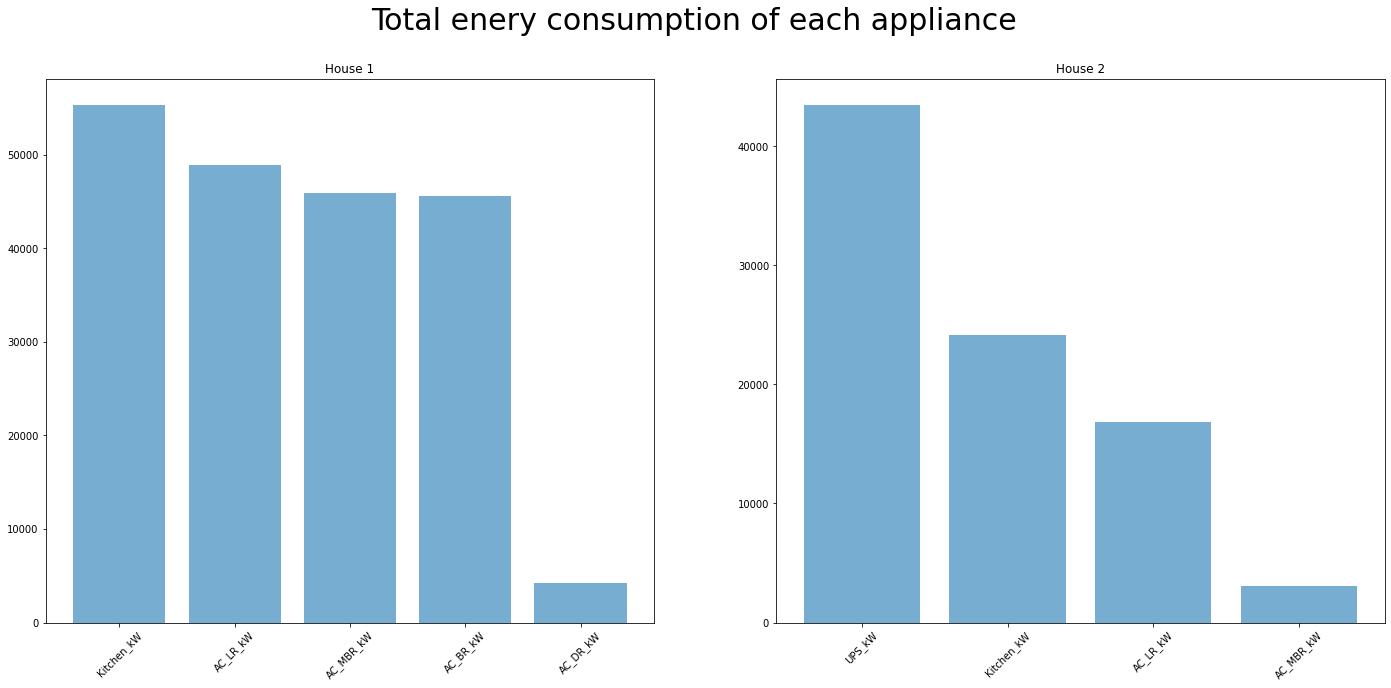

In [9]:
# Plot total energy sonsumption of each appliance from two houses
fig, axes = plt.subplots(1,2,figsize=(24, 10))
plt.suptitle('Total enery consumption of each appliance', fontsize = 30)
cons1 = df[1][df[1].columns.values[2:]].sum().sort_values(ascending=False)
app1 = cons1.index
y_pos1 = np.arange(len(app1))
axes[0].bar(y_pos1, cons1.values,  alpha=0.6)
plt.sca(axes[0])
plt.xticks(y_pos1, app1, rotation = 45)
plt.title('House 1')

cons2 = df[2][df[2].columns.values[2:]].sum().sort_values(ascending=False)
app2 = cons2.index
y_pos2 = np.arange(len(app2))
axes[1].bar(y_pos2, cons2.values, alpha=0.6)
plt.sca(axes[1])
plt.xticks(y_pos2, app2, rotation = 45)
plt.title('House 2')


In [10]:
# Separating house 1 data into train, validation and test data
# df1_train = df[1].loc[:dates[1][250]]
# df1_val = df[1].loc[dates[1][251]:dates[1][325]]
# df1_test = df[1].loc[dates[1][326]:]
# print('df_train.shape: ', df1_train.shape)
# print('df_val.shape: ', df1_val.shape)
# print('df_test.shape: ', df1_test.shape)

df1_train = df[1].loc[:dates[1][70]]
df1_val = df[1].loc[dates[1][71]:dates[1][89]]
df1_test = df[1].loc[dates[1][90]:]
print('df_train.shape: ', df1_train.shape)
print('df_val.shape: ', df1_val.shape)
print('df_test.shape: ', df1_test.shape)

df_train.shape:  (102240, 7)
df_val.shape:  (27360, 7)
df_test.shape:  (15840, 7)


In [11]:
def build_lstm_model(layers):
    model = Sequential()
    i = 0
    for i in range(len(layers) - 2):
        model.add(LSTM(
            input_dim=layers[i],
            units=layers[i+1],
            #stateful=True,
            return_sequences= True if i < len(layers) - 3 else False ))
        model.add(Dropout(0.3))

    model.add(Dense(layers[-1]))
    model.summary()
    return model

model = build_lstm_model([2,64,128,256, 1])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, None, 64)          17152     
_________________________________________________________________
dropout_3 (Dropout)          (None, None, 64)          0         
_________________________________________________________________
lstm_4 (LSTM)                (None, None, 128)         98816     
_________________________________________________________________
dropout_4 (Dropout)          (None, None, 128)         0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 256)               394240    
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                

In [12]:
def process_data(df, dates, x_features, y_features, look_back = 50):
    i = 0
    for date in dates:
        data = df.loc[date]
        len_data = data.shape[0]
        x = np.array([data[x_features].values[i:i+look_back]
                      for i in range(len_data - look_back) ]).reshape(-1,look_back, 2)
        y = data[y_features].values[look_back:,:]
        if i == 0:
            X = x
            Y = y
        else:
            X = np.append(X, x, axis=0)
            Y = np.append(Y, y, axis=0)
        i += 1
    return X,Y

In [13]:
start = time.time()
X_train, y_train = process_data(df[1], dates[1][:89], ['Usage_kW','Sum_kW'], ['Kitchen_kW'])
X_test, y_test = process_data(df[1], dates[1][90:100], ['Usage_kW','Sum_kW'], ['Kitchen_kW'])
print('Process data time: ', time.time() - start)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

Process data time:  70.52773404121399
(123710, 50, 2) (123710, 1) (13900, 50, 2) (13900, 1)


In [14]:
print(df[1].columns.values[2:])

['AC_DR_kW' 'Kitchen_kW' 'AC_BR_kW' 'AC_LR_kW' 'AC_MBR_kW']


In [15]:
start = time.time()
adam = Adam(lr = 5e-5)
model.compile(loss='mean_squared_error', optimizer=adam)
checkpointer = ModelCheckpoint(filepath="./lstm_model.hdf5", verbose=0, save_best_only=True)
hist_lstm = model.fit(
            X_train,
            y_train,
            batch_size=64,
            verbose=1,
            epochs=5,
            validation_split=0.3,
            callbacks=[checkpointer])
print('Finish trainning. Time: ', time.time() - start)

Epoch 1/5
1354/1354 [==============================] - 939s 688ms/step - loss: 0.0260 - val_loss: 0.0247
Epoch 2/5
1354/1354 [==============================] - 921s 680ms/step - loss: 0.0240 - val_loss: 0.0225
Epoch 3/5
1354/1354 [==============================] - 879s 649ms/step - loss: 0.0235 - val_loss: 0.0268
Epoch 4/5
1354/1354 [==============================] - 888s 656ms/step - loss: 0.0231 - val_loss: 0.0225
Epoch 5/5
1354/1354 [==============================] - 905s 668ms/step - loss: 0.0228 - val_loss: 0.0216
Finish trainning. Time:  4531.86488699913


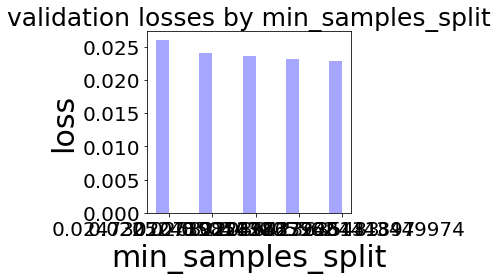

In [16]:
def plot_losses(losses, min_samples_split):
    index = np.arange(len(min_samples_split))
    bar_width = 0.3
    opacity = 0.35

    plt.bar(index, losses, bar_width, alpha=opacity, color='b')
    plt.xlabel('min_samples_split', fontsize=30)
    plt.ylabel('loss', fontsize=30)
    plt.title('validation losses by min_samples_split', fontsize = '25')
    plt.xticks(index + bar_width/2, min_samples_split, fontsize=20 )
    plt.yticks(fontsize=20 )
    plt.rcParams["figure.figsize"] = [24,15]
    plt.tight_layout()


train_loss = hist_lstm.history['loss']
val_loss = hist_lstm.history['val_loss']

plot_losses(train_loss, val_loss)

In [ ]:
model = load_model('lstm_model.hdf5')
pred_lstm = model.predict(X_test).reshape(-1)
pred_lstm_2 = model.predict(X_test)
print(pred_lstm.shape)


In [ ]:
def mse_loss(y_predict, y):
    return np.mean(np.square(y_predict - y))
def mae_loss(y_predict, y):
    return np.mean(np.abs(y_predict - y))


mse_loss_lstm = mse_loss(pred_lstm, y_test)
mae_loss_lstm = mae_loss(pred_lstm, y_test)
print('Mean square error on test set: ', mse_loss_lstm)
print('Mean absolute error on the test set: ', mae_loss_lstm)

In [ ]:
print(df1_test.shape)
print(pred_lstm.shape)
print(pred_lstm_2.shape)
print(y_test.shape)

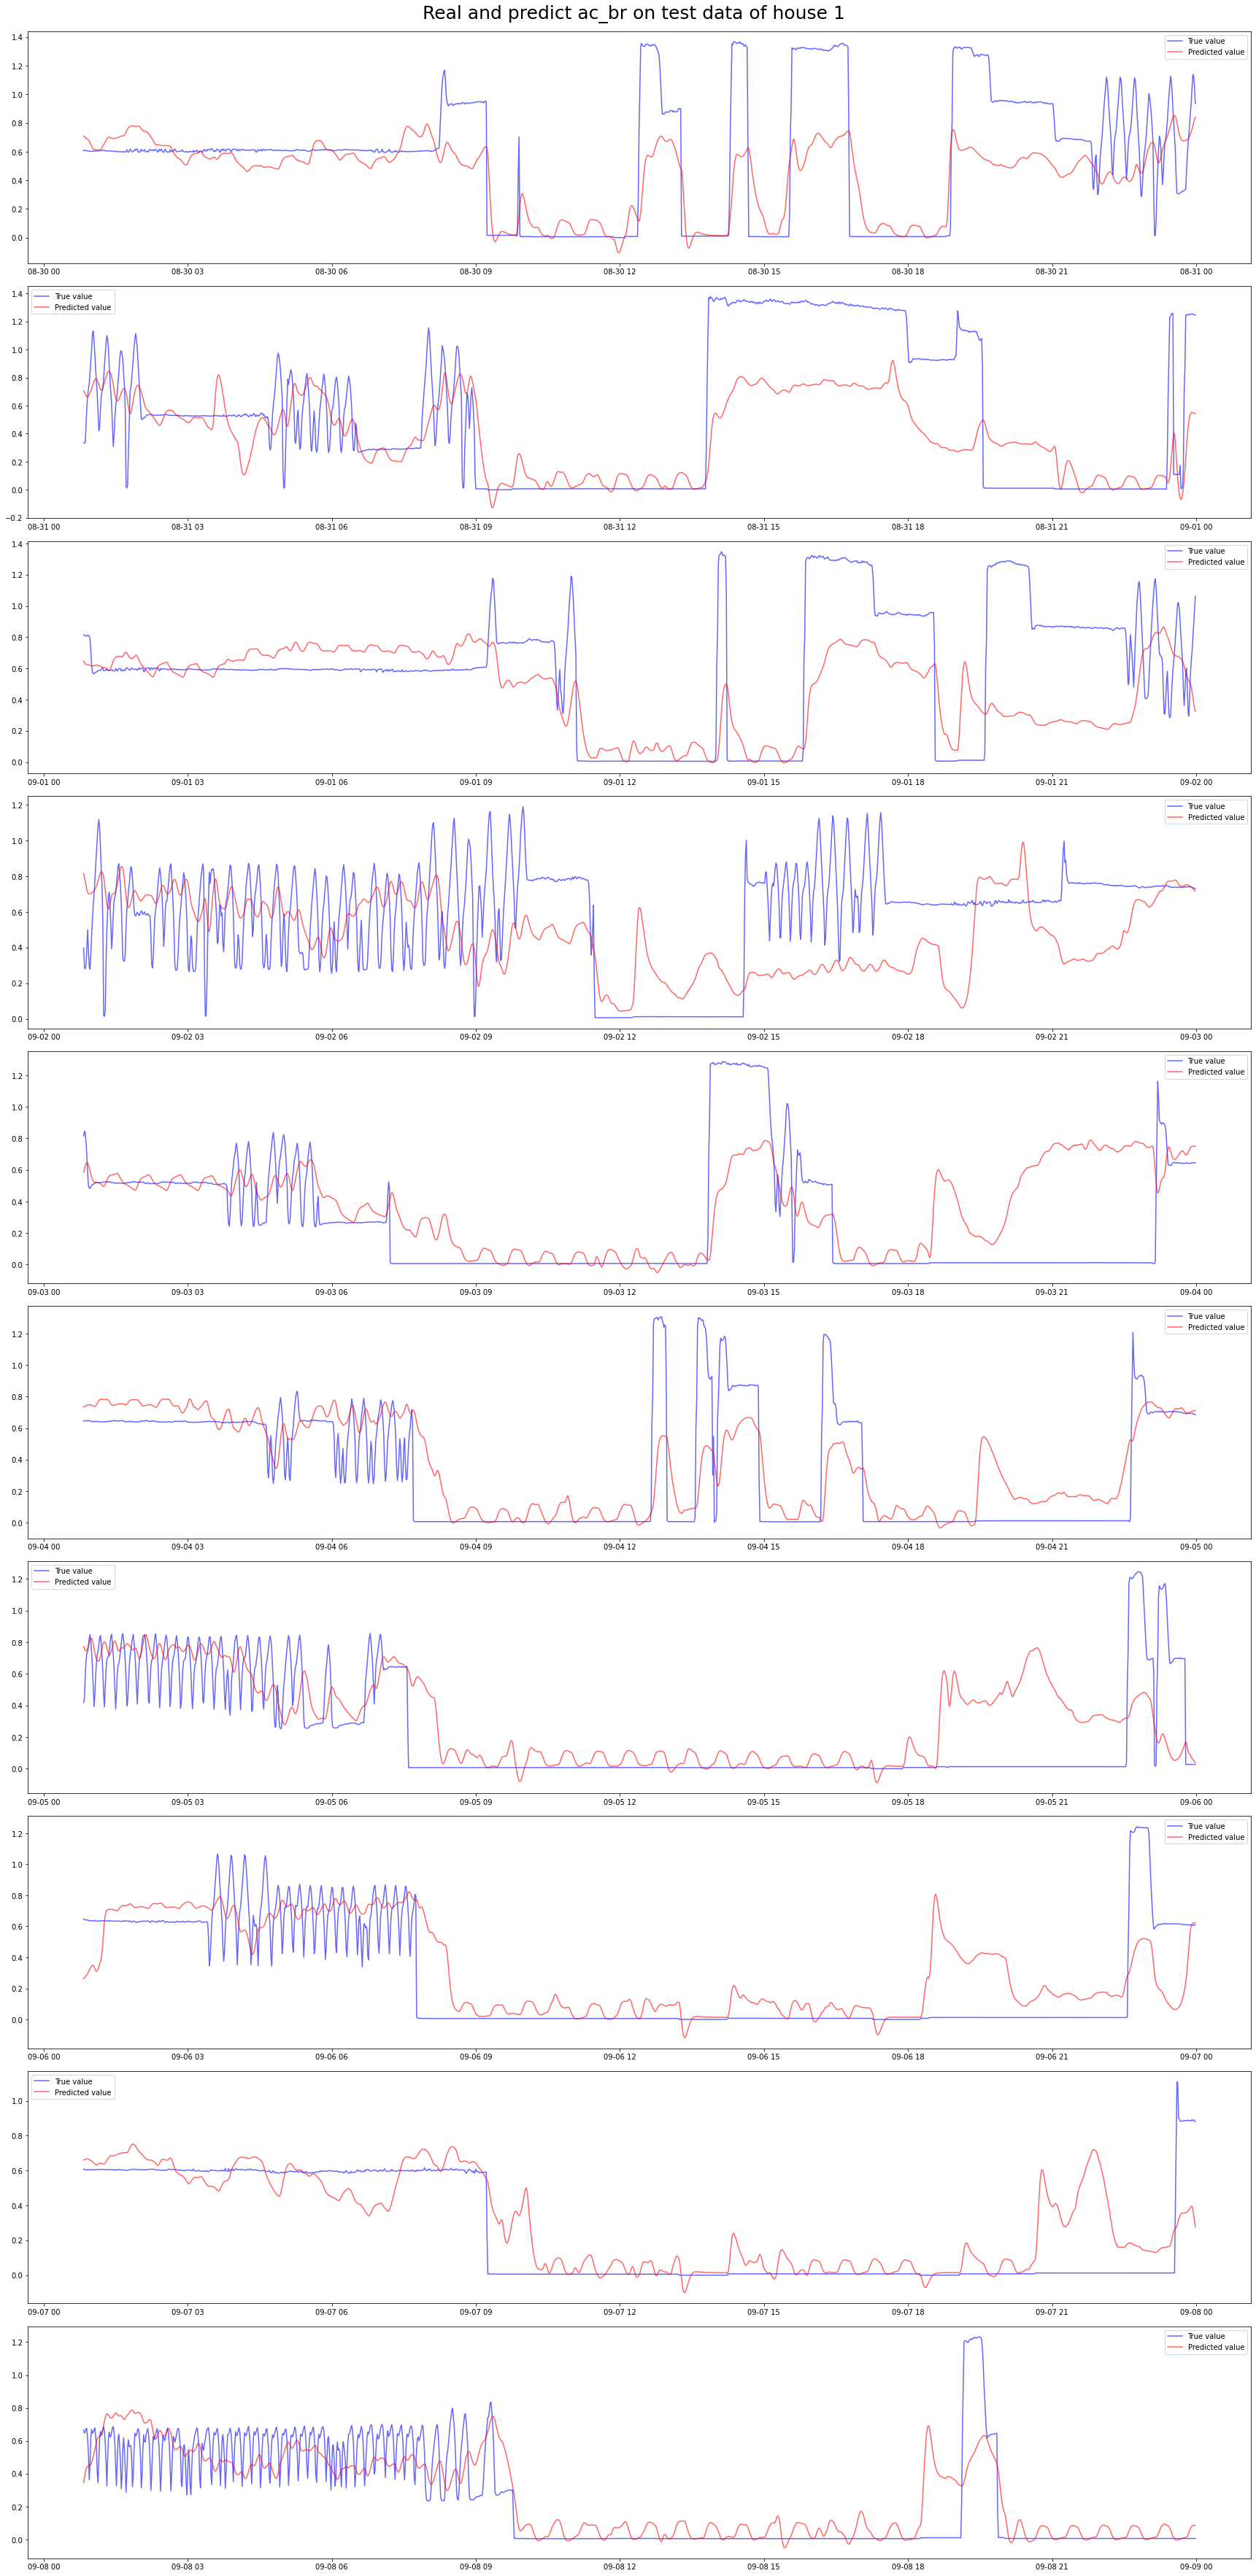

In [104]:
def plot_each_app(df, dates, predict, y_test, title, look_back = 0):
    num_date = len(dates)
    fig, axes = plt.subplots(num_date,1,figsize=(24, num_date*5) )
    plt.suptitle(title, fontsize = '25')
    fig.tight_layout()
    fig.subplots_adjust(top=0.97)
    for i in range(num_date):
        if i == 0: l = 0
        ind = df.loc[dates[i]].index[look_back:]
        display()
        axes.flat[i].plot(ind, y_test[l:l+len(ind)], color = 'blue', alpha = 0.6, label = 'True value')
        axes.flat[i].plot(ind, predict[l:l+len(ind)], color = 'red', alpha = 0.6, label = 'Predicted value')
        axes.flat[i].legend()
        l = l+len(ind)

plot_each_app(df1_test, dates[1][90:100], pred_lstm, y_test,
              'Real and predict ac_br on test data of house 1', look_back = 50)

### Test LST model on house 2

In [29]:
start = time.time()
X_2, y_2 = process_data(df[2], dates[2], ['Usage_kW','Sum_kW'], ['Ac'])
X_2_fc = X_2.reshape(-1, 100)
y_2 = y_2.reshape(-1)
print('Process data time: ', time.time() - start)
print(X_2_fc.shape, y_2.shape)

Process data time:  237.8960452079773
(507350, 100) (507350,)


In [30]:

pred_lstm_h2 = model.predict(X_2).reshape(-1)
mse_loss_lstm_h2 = mse_loss(pred_lstm_h2, y_2)
mae_loss_lstm_h2 = mae_loss(pred_lstm_h2, y_2)
print('Mean square error on test set: ', mse_loss_lstm_h2)
print('Mean absolute error on the test set: ', mae_loss_lstm_h2)

Mean square error on test set:  0.03713161657300573
Mean absolute error on the test set:  0.17032978839335375


In [42]:
print(pred_lstm_h2[50:60])
print(y_2[50:60])

[0.23281835 0.23222794 0.23168012 0.23116723 0.23069611 0.23027815
 0.22991581 0.229612   0.22928415 0.2289174 ]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


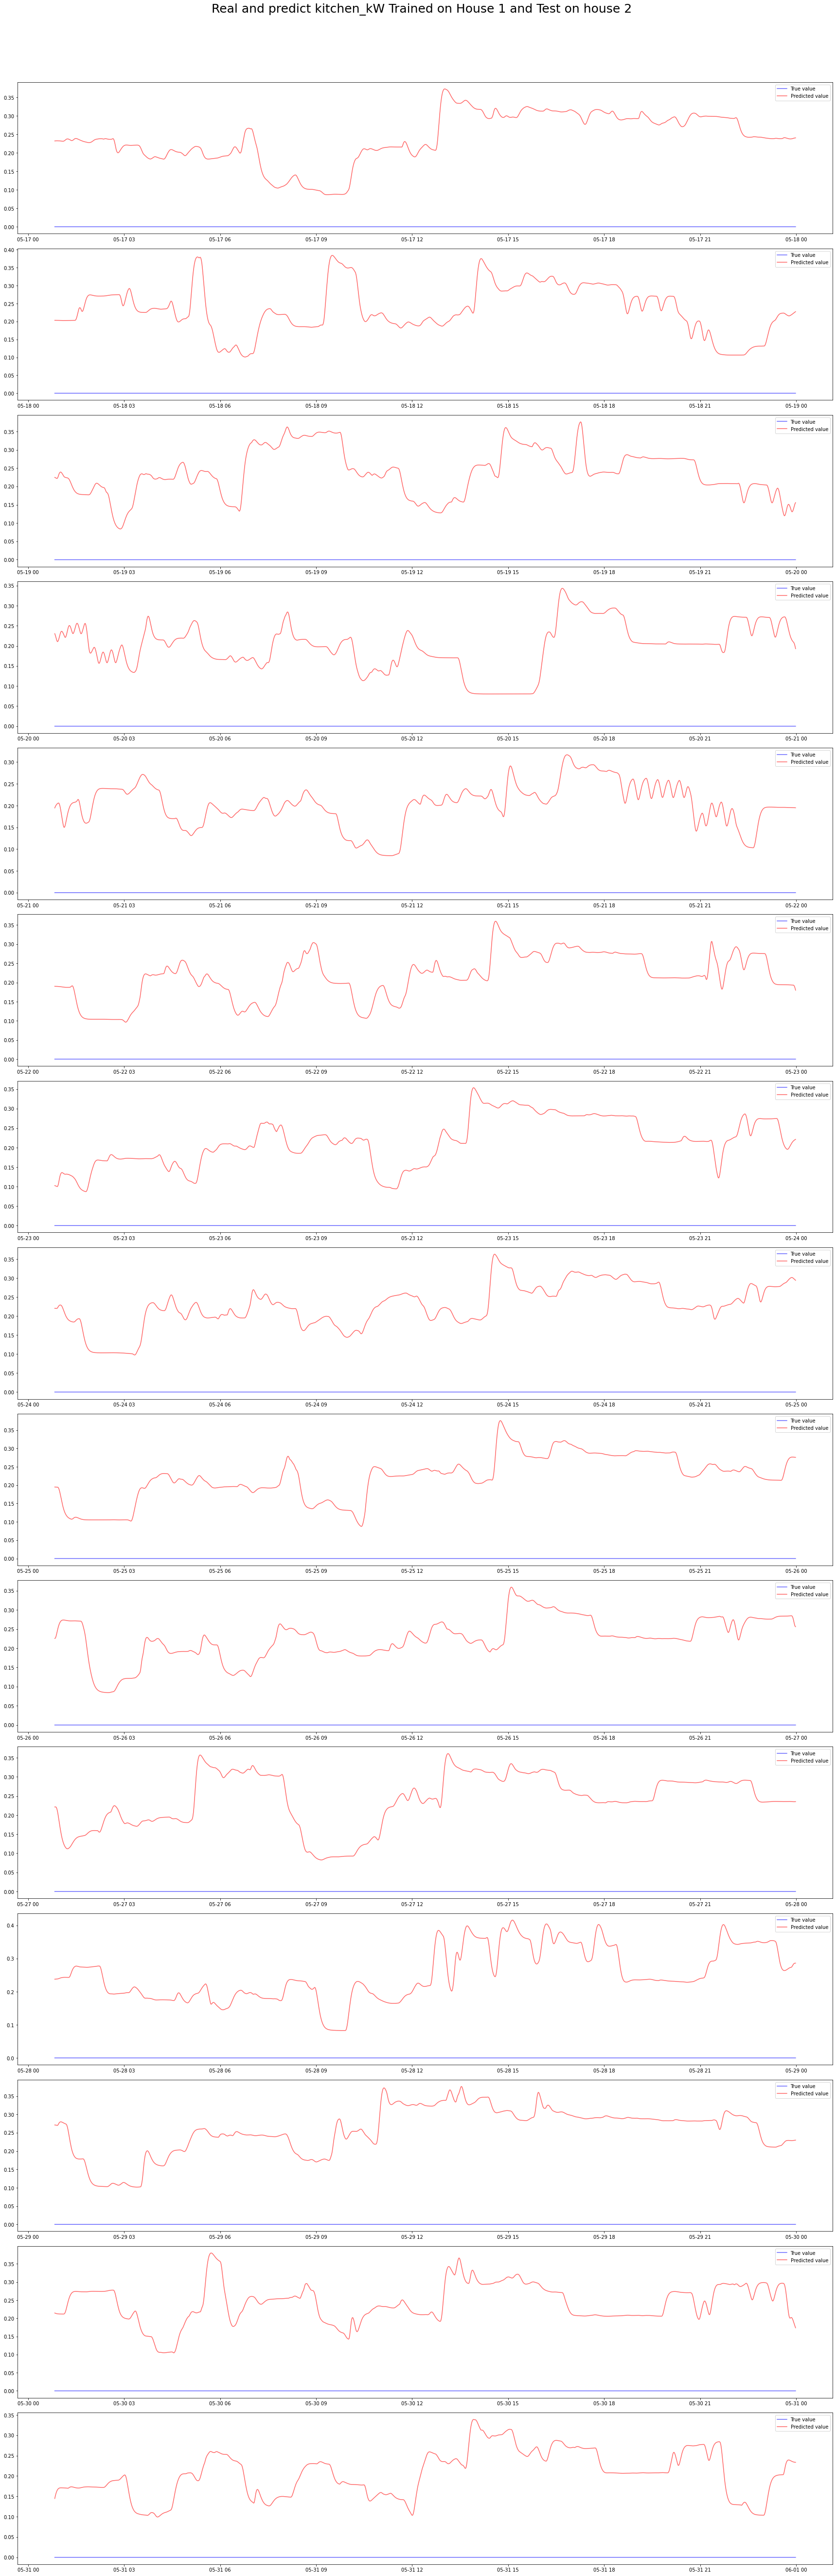

In [36]:
plot_each_app(df[2], dates[2][350:], pred_lstm_h2, y_2,
              'Real and predict kitchen_kW Trained on House 1 and Test on house 2', look_back = 50)